# hw3 - ensembles

## 1 Подготовка данных

Загрузите и предобработайте данные (по своему усмотрению) из hw1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import pickle
import random
from inspect import signature
from typing import Callable

In [2]:
from sklearn.base import BaseEstimator

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor

In [145]:
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split, ShuffleSplit, KFold
from sklearn.metrics import accuracy_score, mean_squared_error

from mlxtend.evaluate import bias_variance_decomp
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Предобработка

In [4]:
X_train = pd.read_csv('train_features_with_answers.csv')

In [5]:
# Delete correlated
correlated_cols = ['Medu', "Walc", "goout", "school", "higher"]
X_train = X_train.drop(columns=correlated_cols)

In [6]:
# complicated features
free_coef = X_train['freetime'] / X_train['studytime']
X_train['free_coef'] = free_coef
misses = np.abs(X_train['absences']) * X_train['freetime']
X_train['misses'] = misses

In [7]:
# replace odd to nan

# sex
if len(X_train["sex"].unique()) > 2:
    odd_values = list(X_train["sex"].unique())
    odd_values.remove("M")
    odd_values.remove("F")
    for odd_sex in odd_values:
        X_train["sex"] = X_train["sex"].replace(odd_sex, np.nan)

# age
X_train.loc[(X_train['age'] > 22) | (X_train['age'] < 15), 'age'] = np.nan

In [8]:
# encoding
cols_to_encode = [
    'famsize', 'Pstatus', 'Mjob', 'Fjob', 
    'reason', 'guardian', 'schoolsup', 'famsup', 
    'paid', 'activities', 'nursery', 'internet', 
    'romantic', 
]

for col in cols_to_encode:
    if len(X_train[col].unique()) == 2:
        X_train[col].replace(list(X_train[col].unique()), [False, True], inplace=True)
    else:
        X_train[col].replace(list(X_train[col].unique()), [i for i in range(len(X_train[col].unique()))], inplace=True)

In [9]:
X_train['sex'].replace(['M', 'F'], [False, True], inplace=True)
X_train['address'].replace(['U', 'R'], [False, True], inplace=True)

<AxesSubplot:>

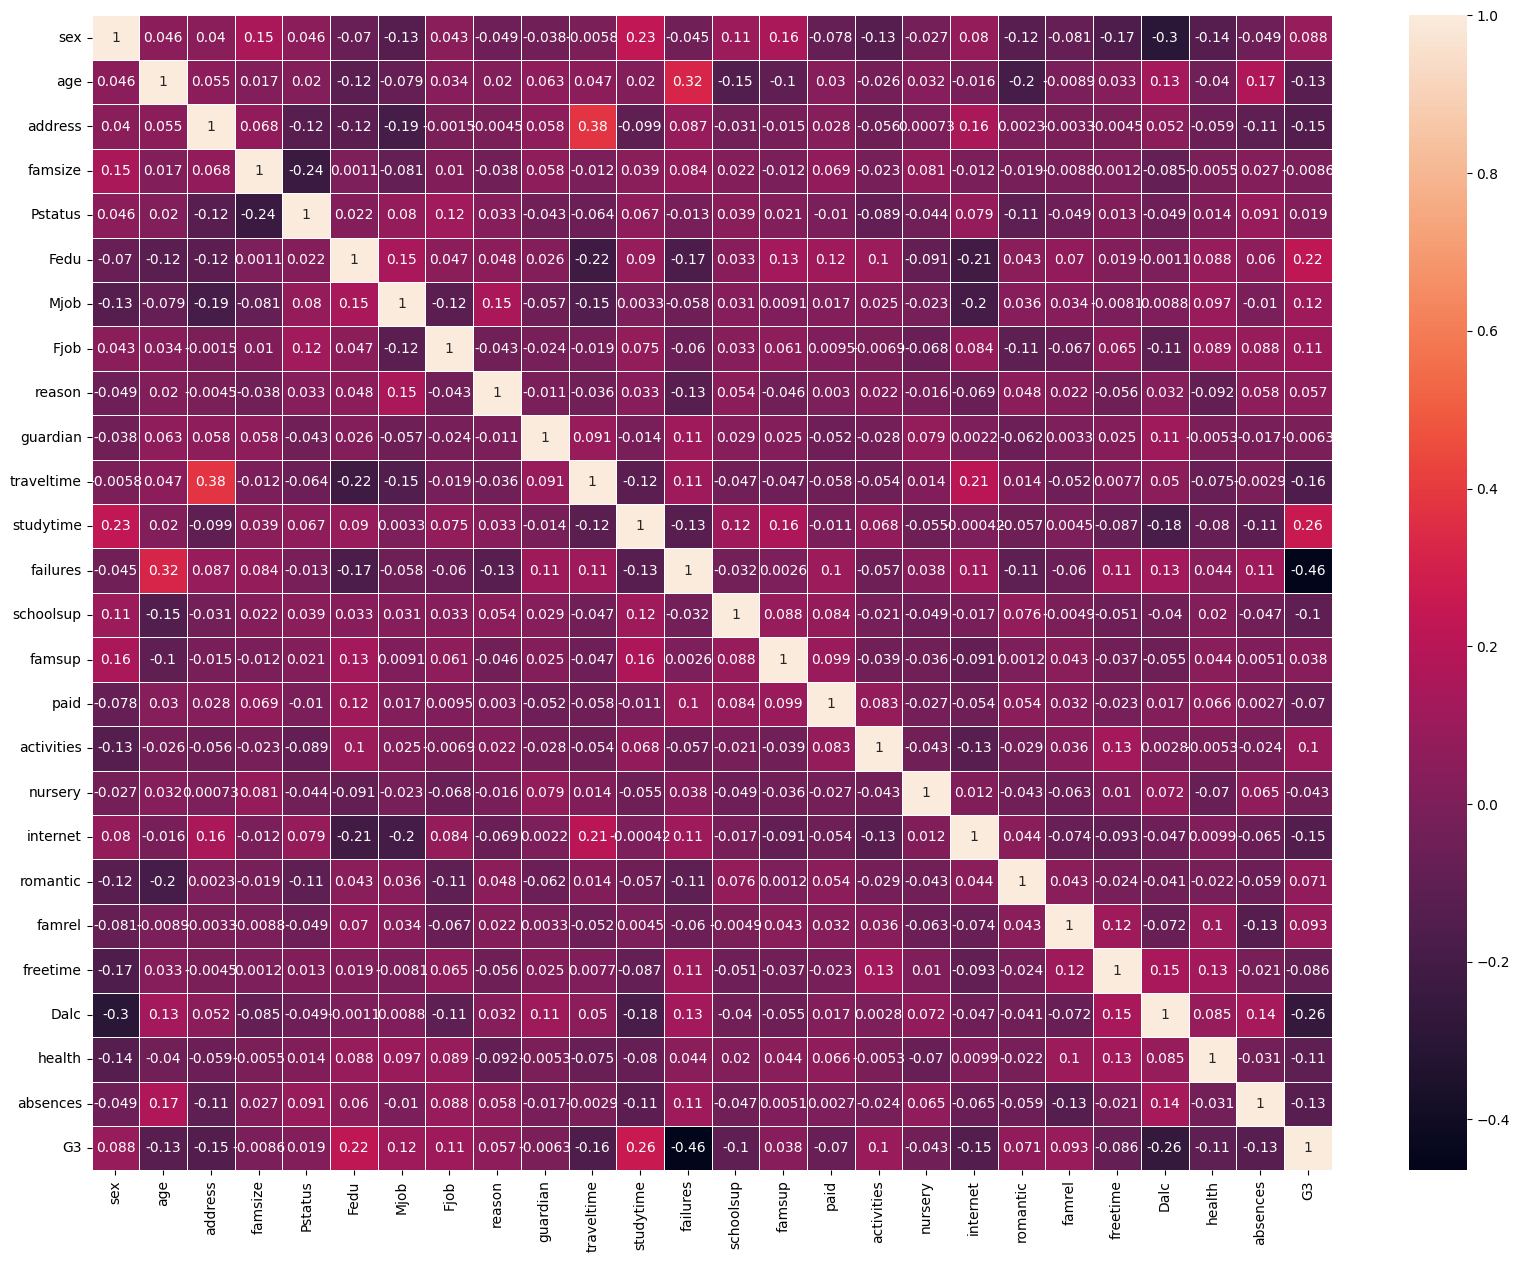

In [10]:
X_train_copy = X_train.copy()
X_train_copy = X_train_copy.drop(columns=['free_coef', 'misses'])
X_train_copy.fillna(0)

fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(X_train_copy.corr(method = 'spearman'), annot=True, linewidths=.5, ax=ax)

In [11]:
# find highly correlated (>= 0.5)
correlated_threshold = 0.35

spearman_corr = X_train_copy.corr(method = 'spearman')
spearman_corr_correlated = spearman_corr[((spearman_corr >= correlated_threshold) & (spearman_corr < 1.0)) | ((spearman_corr <= -correlated_threshold) & (spearman_corr >= -1.0))]
correlated_pairs = []
cor_cols_count = {}
for col_name in spearman_corr_correlated.columns:    
    a = spearman_corr_correlated[spearman_corr_correlated[col_name].notnull()].index.tolist()
    if len(a) != 0:
        for cor_name in a:
            if 'G3' != col_name and 'G3' != cor_name:
                if cor_name not in cor_cols_count.keys():
                    cor_cols_count[cor_name] = 1
                else:
                    cor_cols_count[cor_name] += 1
                # if col_name not in cor_cols_count.keys():
                #     cor_cols_count[col_name] = 1
                # else:
                #     cor_cols_count[col_name] += 1
            
            pair = set([col_name, cor_name])
            if pair not in correlated_pairs and 'G3' not in pair:
                correlated_pairs.append(pair)

correlated_pairs

[{'address', 'traveltime'}]

In [12]:
# models to replace nans
design = X_train.loc[:, X_train.columns != "G3"]

In [13]:
# age
design_age = design.copy()
design_age = design_age.drop(columns=['address', 'sex'])

design_age_wout_nan = design_age[design_age['age'].notnull()]

y_age = design_age_wout_nan['age']
X_age = design_age_wout_nan.loc[:, design_age_wout_nan.columns != "age"]

X_age_train, X_age_validate, y_age_train, y_age_validate = train_test_split(X_age, y_age, test_size=0.1, random_state=42)

best_KnnAge = None
best_score = 0

print("Age replacement model training\n")

for weight in ["uniform", 'distance']:
    for i in range(20): 
        KnnAge = KNeighborsClassifier(n_neighbors=i+1, weights=weight)
        KnnAge.fit(X_age_train, y_age_train)
        score = mean_squared_error(KnnAge.predict(X_age_validate), y_age_validate)
        if score > best_score:
            best_KnnAge = KnnAge
            best_score = score
        print(f"weight '{weight}', k={i}, score: {score}")

print(f"\nbest model score: {accuracy_score(best_KnnAge.predict(X_age_validate), y_age_validate)}")

for nan_age_i in X_train[X_train['age'].isnull()].index.tolist():
    predicted_age = best_KnnAge.predict([design_age.loc[:, design_age.columns != "age"].iloc[nan_age_i]])
    X_train.loc[nan_age_i, "age"] = predicted_age[0]
    design.loc[nan_age_i, "age"] = predicted_age[0]

Age replacement model training

weight 'uniform', k=0, score: 3.5714285714285716
weight 'uniform', k=1, score: 3.9523809523809526
weight 'uniform', k=2, score: 3.4047619047619047
weight 'uniform', k=3, score: 3.3095238095238093
weight 'uniform', k=4, score: 4.023809523809524
weight 'uniform', k=5, score: 3.8333333333333335
weight 'uniform', k=6, score: 3.5476190476190474
weight 'uniform', k=7, score: 3.119047619047619
weight 'uniform', k=8, score: 3.0238095238095237
weight 'uniform', k=9, score: 3.1904761904761907
weight 'uniform', k=10, score: 3.1666666666666665
weight 'uniform', k=11, score: 3.1904761904761907
weight 'uniform', k=12, score: 2.880952380952381
weight 'uniform', k=13, score: 2.9761904761904763
weight 'uniform', k=14, score: 2.9761904761904763
weight 'uniform', k=15, score: 2.9047619047619047
weight 'uniform', k=16, score: 3.0952380952380953
weight 'uniform', k=17, score: 3.1904761904761907
weight 'uniform', k=18, score: 3.119047619047619
weight 'uniform', k=19, score: 3

/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted w

In [14]:
# sex
design_sex = design.copy()
design_sex = design_sex.drop(columns=['address'])

design_sex_wout_nan = design_sex[design_sex['sex'].notnull()]

y_sex = design_sex_wout_nan['sex']
y_sex.replace([False, True], [0, 1], inplace=True)
X_sex = design_sex_wout_nan.loc[:, design_sex_wout_nan.columns != "sex"]

X_sex_train, X_sex_validate, y_sex_train, y_sex_validate = train_test_split(X_sex, y_sex, test_size=0.2, random_state=42)

best_KnnSex = None
best_score = 0

print("Sex replacement model training\n")

for weight in ["uniform", 'distance']:
    for i in range(20):    
        KnnSex = KNeighborsClassifier(n_neighbors=i+1, weights=weight)
        KnnSex.fit(X_sex_train, y_sex_train)
        score = accuracy_score(KnnSex.predict(X_sex_validate), y_sex_validate)
        if score > best_score:
            best_KnnSex = KnnSex
            best_score = score
        print(f"weight '{weight}', k={i}, score: {score}")

print(f"\nbest model score: {accuracy_score(best_KnnSex.predict(X_sex_validate), y_sex_validate)}")

for nan_sex_i in X_train[X_train['sex'].isnull()].index.tolist():
    predicted_sex = best_KnnSex.predict([design_sex.loc[:, design_sex.columns != "sex"].iloc[nan_sex_i]])
    predicted_sex = True if predicted_sex[0] == 1 else False
    X_train.loc[nan_sex_i, "sex"] = predicted_sex
    design.loc[nan_sex_i, "sex"] = predicted_sex

Sex replacement model training

weight 'uniform', k=0, score: 0.6
weight 'uniform', k=1, score: 0.5555555555555556
weight 'uniform', k=2, score: 0.5555555555555556
weight 'uniform', k=3, score: 0.5666666666666667
weight 'uniform', k=4, score: 0.4888888888888889
weight 'uniform', k=5, score: 0.5777777777777777
weight 'uniform', k=6, score: 0.5111111111111111
weight 'uniform', k=7, score: 0.5555555555555556
weight 'uniform', k=8, score: 0.5333333333333333
weight 'uniform', k=9, score: 0.5666666666666667
weight 'uniform', k=10, score: 0.5555555555555556
weight 'uniform', k=11, score: 0.5222222222222223
weight 'uniform', k=12, score: 0.5333333333333333
weight 'uniform', k=13, score: 0.5777777777777777
weight 'uniform', k=14, score: 0.5777777777777777
weight 'uniform', k=15, score: 0.5888888888888889
weight 'uniform', k=16, score: 0.5666666666666667
weight 'uniform', k=17, score: 0.5666666666666667
weight 'uniform', k=18, score: 0.5555555555555556
weight 'uniform', k=19, score: 0.5555555555

/tmp/ipykernel_232135/825966021.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_sex.replace([False, True], [0, 1], inplace=True)
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-pa

In [15]:
# address
design_address = design.copy()

design_address_wout_nan = design_address[design_address['address'].notnull()]

y_address = design_address_wout_nan['address']
y_address.replace([False, True], [0, 1], inplace=True)
X_address = design_address_wout_nan.loc[:, design_address_wout_nan.columns != "address"]

X_address_train, X_address_validate, y_address_train, y_address_validate = train_test_split(X_address, y_address, test_size=0.2, random_state=42)

best_KnnAddress = None
best_score = 0

print("Address replacement model training\n")

for weight in ["uniform", 'distance']:
    for i in range(20):    
        KnnAddress = KNeighborsClassifier(n_neighbors=9)
        KnnAddress.fit(X_address_train, y_address_train)
        score = KnnAddress.score(X_address_validate, y_address_validate)
        if score > best_score:
            best_KnnAddress = KnnAddress
            best_score = score
        print(f"weight '{weight}', k={i}, score: {score}")

print(f"\nbest model score: {accuracy_score(best_KnnAddress.predict(X_address_validate), y_address_validate)}")

for nan_address_i in X_train[X_train['address'].isnull()].index.tolist():
    predicted_address = best_KnnAddress.predict([design_address.loc[:, design_address.columns != "address"].iloc[nan_address_i]])
    predicted_address = True if predicted_address[0] == 1 else False
    X_train.loc[nan_address_i, "address"] = predicted_address

/tmp/ipykernel_232135/3645692025.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_address.replace([False, True], [0, 1], inplace=True)


Address replacement model training

weight 'uniform', k=0, score: 0.7333333333333333
weight 'uniform', k=1, score: 0.7333333333333333
weight 'uniform', k=2, score: 0.7333333333333333
weight 'uniform', k=3, score: 0.7333333333333333
weight 'uniform', k=4, score: 0.7333333333333333
weight 'uniform', k=5, score: 0.7333333333333333
weight 'uniform', k=6, score: 0.7333333333333333
weight 'uniform', k=7, score: 0.7333333333333333
weight 'uniform', k=8, score: 0.7333333333333333
weight 'uniform', k=9, score: 0.7333333333333333
weight 'uniform', k=10, score: 0.7333333333333333
weight 'uniform', k=11, score: 0.7333333333333333
weight 'uniform', k=12, score: 0.7333333333333333
weight 'uniform', k=13, score: 0.7333333333333333
weight 'uniform', k=14, score: 0.7333333333333333
weight 'uniform', k=15, score: 0.7333333333333333
weight 'uniform', k=16, score: 0.7333333333333333
weight 'uniform', k=17, score: 0.7333333333333333
weight 'uniform', k=18, score: 0.7333333333333333
weight 'uniform', k=19, 

/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted w

In [16]:
X_train

,sex,age,address,famsize,Pstatus,Fedu,Mjob,Fjob,reason,guardian,...,internet,romantic,famrel,freetime,Dalc,health,absences,G3,free_coef,misses
0,False,18.0,False,False,False,3,0,0,0,0,...,False,False,4,3,2,3,0,9,3.00,0
1,False,17.0,True,False,False,3,1,1,1,1,...,False,True,3,3,3,3,16,12,3.00,48
2,False,15.0,False,True,False,4,2,1,1,0,...,False,True,5,5,1,5,0,13,2.50,0
3,False,17.0,True,True,False,3,3,1,1,0,...,False,False,4,5,1,2,4,11,2.50,20
4,True,20.0,True,True,False,1,2,1,0,2,...,False,False,1,2,1,2,8,12,1.00,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,False,15.0,False,True,False,2,2,1,0,0,...,False,True,3,3,1,3,0,10,0.75,0
450,True,15.0,False,True,False,2,2,1,0,0,...,False,True,5,1,1,3,4,10,0.25,4
451,False,16.0,False,True,False,4,3,0,0,0,...,False,True,5,3,1,5,4,15,3.00,12
452,True,15.0,True,False,False,1,0,0,2,1,...,False,True,5,4,1,4,0,10,2.00,0


In [17]:
for column_name in list(X_train.columns):
    print(f"Column '{column_name}':\n\tUnique values: {list(X_train[column_name].unique())}\tCount: {len(X_train[column_name].unique())}")

Column 'sex':
	Unique values: [False, True]	Count: 2
Column 'age':
	Unique values: [18.0, 17.0, 15.0, 20.0, 16.0, 19.0, 21.0, 22.0]	Count: 8
Column 'address':
	Unique values: [False, True]	Count: 2
Column 'famsize':
	Unique values: [False, True]	Count: 2
Column 'Pstatus':
	Unique values: [False, True]	Count: 2
Column 'Fedu':
	Unique values: [3, 4, 1, 2, 0]	Count: 5
Column 'Mjob':
	Unique values: [0, 1, 2, 3, 4]	Count: 5
Column 'Fjob':
	Unique values: [0, 1, 2, 3, 4]	Count: 5
Column 'reason':
	Unique values: [0, 1, 2, 3]	Count: 4
Column 'guardian':
	Unique values: [0, 1, 2]	Count: 3
Column 'traveltime':
	Unique values: [1, 3, 2, 4]	Count: 4
Column 'studytime':
	Unique values: [1, 2, 3, 4]	Count: 4
Column 'failures':
	Unique values: [0, 1, 2, 3]	Count: 4
Column 'schoolsup':
	Unique values: [False, True]	Count: 2
Column 'famsup':
	Unique values: [False, True]	Count: 2
Column 'paid':
	Unique values: [False, True]	Count: 2
Column 'activities':
	Unique values: [False, True]	Count: 2
Column '

### Базовые алгоритмы

In [18]:
X_training, X_validate, y_training, y_validate = train_test_split(X_train.drop(columns = ['G3']), X_train['G3'], test_size=0.1, random_state=42)

In [19]:
def get_best_params(model, parameters, X_training, y_training):
    model_grid = GridSearchCV(
        model, parameters, scoring='neg_mean_squared_error', refit=True
    )
    model_grid.fit(X_training.to_numpy(), y_training.to_numpy())
    best_model_params = model_grid.best_params_
    print(best_model_params)
    return best_model_params


def get_model_info(model, X_training, y_training, X_validate, y_validate):
    loss, bias, var = bias_variance_decomp(
        model, X_training.to_numpy(), y_training.to_numpy(), X_validate.to_numpy(), y_validate.to_numpy(), 
        loss='mse',
        random_seed=123)

    if type(model).__name__ == 'Pipeline':
        model_name = '+'.join(list(model.named_steps.keys()))
    else:
        model_name = type(model).__name__

    print(f'Average {model_name} expected loss: %.3f' % loss)
    print(f'Average {model_name} bias: %.3f' % bias)
    print(f'Average {model_name} variance: %.3f' % var)
    
    model.fit(X_training.to_numpy(), y_training.to_numpy())
    print(f"Train MSE score: {mean_squared_error(model.predict(X_training), y_training)}")
    print(f"Validation MSE score: {mean_squared_error(model.predict(X_validate), y_validate)}")

    return {'expected_loss': loss, 'bias': bias, 'variance': var, 'valid_score': mean_squared_error(model.predict(X_validate), y_validate)}

In [20]:
models = []

#### KNN

In [101]:
KNN_classifier = make_pipeline(StandardScaler(), KNeighborsClassifier())
parameters = {
    'kneighborsclassifier__n_neighbors': [2*i+1 for i in range(20)], 
    'kneighborsclassifier__weights':("uniform", "distance"), 
    'kneighborsclassifier__metric': ('l2', 'euclidean', 'manhattan')
}

best_KNN_classifier_params = get_best_params(KNN_classifier, parameters, X_training, y_training)

best_KNN_classifier = make_pipeline(
    StandardScaler(), 
    KNeighborsClassifier(
        n_neighbors=best_KNN_classifier_params["kneighborsclassifier__n_neighbors"],
        metric=best_KNN_classifier_params["kneighborsclassifier__metric"],
        weights=best_KNN_classifier_params["kneighborsclassifier__weights"]
    )
)

info = get_model_info(best_KNN_classifier, X_training, y_training, X_validate, y_validate)
info["model_name"] = 'KNN classifier'
info['model'] = make_pipeline(
    StandardScaler(), 
    KNeighborsClassifier(
        n_neighbors=best_KNN_classifier_params["kneighborsclassifier__n_neighbors"],
        metric=best_KNN_classifier_params["kneighborsclassifier__metric"],
        weights=best_KNN_classifier_params["kneighborsclassifier__weights"]
    )
)

models.append(info)

/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 29, 'kneighborsclassifier__weights': 'uniform'}
Average standardscaler+kneighborsclassifier expected loss: 7.938
Average standardscaler+kneighborsclassifier bias: 5.263
Average standardscaler+kneighborsclassifier variance: 2.675
Train MSE score: 9.426470588235293
Validation MSE score: 6.108695652173913


/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [102]:
KNN_regressor = make_pipeline(StandardScaler(), KNeighborsRegressor())
parameters = {
    'kneighborsregressor__n_neighbors': [2*i+1 for i in range(20)], 
    'kneighborsregressor__weights':("uniform", "distance"), 
    'kneighborsregressor__metric': ('l2', 'euclidean', 'manhattan')
}

best_KNN_regressor_params = get_best_params(KNN_regressor, parameters, X_training, y_training)

best_KNN_regressor = make_pipeline(
    StandardScaler(), 
    KNeighborsRegressor(
        n_neighbors=best_KNN_regressor_params["kneighborsregressor__n_neighbors"],
        metric=best_KNN_regressor_params["kneighborsregressor__metric"],
        weights=best_KNN_regressor_params["kneighborsregressor__weights"]
    )
)

info = get_model_info(best_KNN_regressor, X_training, y_training, X_validate, y_validate)
info["model_name"] = 'KNN regressor'
info['model'] = make_pipeline(
    StandardScaler(), 
    KNeighborsRegressor(
        n_neighbors=best_KNN_regressor_params["kneighborsregressor__n_neighbors"],
        metric=best_KNN_regressor_params["kneighborsregressor__metric"],
        weights=best_KNN_regressor_params["kneighborsregressor__weights"]
    )
)

models.append(info)

{'kneighborsregressor__metric': 'manhattan', 'kneighborsregressor__n_neighbors': 9, 'kneighborsregressor__weights': 'distance'}
Average standardscaler+kneighborsregressor expected loss: 6.597
Average standardscaler+kneighborsregressor bias: 5.552
Average standardscaler+kneighborsregressor variance: 1.046
Train MSE score: 0.0
Validation MSE score: 5.309874751140705


/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


#### Bayes

In [103]:
Bayes = make_pipeline(MinMaxScaler(), CategoricalNB())
# Bayes = CategoricalNB()

get_model_info(Bayes, X_training, y_training, X_validate, y_validate)

Average minmaxscaler+categoricalnb expected loss: 11.125
Average minmaxscaler+categoricalnb bias: 7.689
Average minmaxscaler+categoricalnb variance: 3.436
Train MSE score: 10.852941176470589
Validation MSE score: 8.130434782608695


/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


{'expected_loss': 11.125108695652175,
 'bias': 7.6890059782608695,
 'variance': 3.4361027173913046,
 'valid_score': 8.130434782608695}

#### Linear Regression

In [104]:
Regression = make_pipeline(StandardScaler(), LinearRegression())

info = get_model_info(Regression, X_training, y_training, X_validate, y_validate)

info["model_name"] = 'Linear regression'
info['model'] = make_pipeline(StandardScaler(), LinearRegression())

models.append(info)

Average standardscaler+linearregression expected loss: 6.740
Average standardscaler+linearregression bias: 6.210
Average standardscaler+linearregression variance: 0.530
Train MSE score: 7.25492598057891
Validation MSE score: 6.232171964356398


/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [105]:
RidgeRegression = make_pipeline(StandardScaler(), Ridge())
parameters = {
    'ridge__alpha': [0.03 * i ** 2 + 0.1 for i in range(20)],
}

best_RidgeRegression_params = get_best_params(RidgeRegression, parameters, X_training, y_training)

best_RidgeRegression = make_pipeline(
    StandardScaler(), 
    Ridge(
        alpha=best_RidgeRegression_params["ridge__alpha"]
    )
)

info = get_model_info(best_RidgeRegression, X_training, y_training, X_validate, y_validate)
info["model_name"] = 'Linear regression with regularization'
info['model'] = make_pipeline(
    StandardScaler(), 
    Ridge(
        alpha=best_RidgeRegression_params["ridge__alpha"]
    )
)

models.append(info)

{'ridge__alpha': 10.93}
Average standardscaler+ridge expected loss: 6.646
Average standardscaler+ridge bias: 6.170
Average standardscaler+ridge variance: 0.476
Train MSE score: 7.257489342403438
Validation MSE score: 6.191566156693783


/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


#### SVM

In [106]:
SVM_poly = make_pipeline(StandardScaler(), SVC(kernel='poly'))
parameters = {
    'svc__C': [0.05, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0], 
    'svc__degree': [i+1 for i in range(3)], 
    'svc__gamma':("scale", "auto")
}

best_SVM_poly_params = get_best_params(SVM_poly, parameters, X_training, y_training)

best_SVM_poly = make_pipeline(
    StandardScaler(), 
    SVC(
        kernel='poly',
        C=best_SVM_poly_params["svc__C"],
        degree=best_SVM_poly_params["svc__degree"],
        gamma=best_SVM_poly_params["svc__gamma"]
    )
)

info = get_model_info(best_SVM_poly, X_training, y_training, X_validate, y_validate)
info["model_name"] = 'polinomial SVM'
info['model'] = make_pipeline(
    StandardScaler(), 
    SVC(
        kernel='poly',
        C=best_SVM_poly_params["svc__C"],
        degree=best_SVM_poly_params["svc__degree"],
        gamma=best_SVM_poly_params["svc__gamma"]
    )
)

models.append(info)

/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'svc__C': 0.5, 'svc__degree': 1, 'svc__gamma': 'scale'}
Average standardscaler+svc expected loss: 6.688
Average standardscaler+svc bias: 5.294
Average standardscaler+svc variance: 1.395
Train MSE score: 8.39950980392157
Validation MSE score: 5.717391304347826


/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [107]:
SVM = make_pipeline(StandardScaler(), SVC())
parameters = {
    'svc__C': [0.05, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0], 
    'svc__gamma':("scale", "auto"), 
    'svc__kernel': ('linear', 'rbf', 'sigmoid')
}

best_SVM_params = get_best_params(SVM, parameters, X_training, y_training)

best_SVM = make_pipeline(
    StandardScaler(), 
    SVC(
        kernel=best_SVM_params['svc__kernel'],
        C=best_SVM_params["svc__C"],
        gamma=best_SVM_params["svc__gamma"]
    )
)

info = get_model_info(best_SVM, X_training, y_training, X_validate, y_validate)
info["model_name"] = 'SVM'
info['model'] = make_pipeline(
    StandardScaler(), 
    SVC(
        kernel=best_SVM_params['svc__kernel'],
        C=best_SVM_params["svc__C"],
        gamma=best_SVM_params["svc__gamma"]
    )
)

models.append(info)

/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'svc__C': 1.0, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Average standardscaler+svc expected loss: 5.858
Average standardscaler+svc bias: 4.518
Average standardscaler+svc variance: 1.341
Train MSE score: 6.088235294117647
Validation MSE score: 5.217391304347826


/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


#### Tree

In [108]:
Tree_reg = make_pipeline(DecisionTreeRegressor())
parameters = {
    'decisiontreeregressor__criterion': ['squared_error', 'friedman_mse'], 
    'decisiontreeregressor__splitter': ['best', 'random'], 
    'decisiontreeregressor__max_depth': [2 + i for i in range(10)],
    'decisiontreeregressor__min_samples_leaf': [1, 5, 10, 15, 20, 25, 30]
}

best_tree_reg_params = get_best_params(Tree_reg, parameters, X_training, y_training)

best_tree_reg = make_pipeline(
    DecisionTreeRegressor(
        criterion=best_tree_reg_params['decisiontreeregressor__criterion'],
        splitter=best_tree_reg_params['decisiontreeregressor__splitter'],
        max_depth=best_tree_reg_params['decisiontreeregressor__max_depth'],
        min_samples_leaf=best_tree_reg_params['decisiontreeregressor__min_samples_leaf'],
    )
)

info = get_model_info(best_tree_reg, X_training, y_training, X_validate, y_validate)
info["model_name"] = 'regression tree'
info['model'] = make_pipeline(
    DecisionTreeRegressor(
        criterion=best_tree_reg_params['decisiontreeregressor__criterion'],
        splitter=best_tree_reg_params['decisiontreeregressor__splitter'],
        max_depth=best_tree_reg_params['decisiontreeregressor__max_depth'],
        min_samples_leaf=best_tree_reg_params['decisiontreeregressor__min_samples_leaf'],
    )
)

models.append(info)

{'decisiontreeregressor__criterion': 'squared_error', 'decisiontreeregressor__max_depth': 8, 'decisiontreeregressor__min_samples_leaf': 25, 'decisiontreeregressor__splitter': 'random'}
Average decisiontreeregressor expected loss: 7.150
Average decisiontreeregressor bias: 5.223
Average decisiontreeregressor variance: 1.926
Train MSE score: 8.432609209634101
Validation MSE score: 7.873156769540407


/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [109]:
Tree_cl = make_pipeline(DecisionTreeClassifier())
parameters = {
    'decisiontreeclassifier__criterion': ['gini', 'entropy', 'log_loss'], 
    'decisiontreeclassifier__splitter': ['best', 'random'], 
    'decisiontreeclassifier__max_depth': [2 + i for i in range(10)],
    'decisiontreeclassifier__min_samples_leaf': [1, 5, 10, 15, 20, 25, 30]
}

best_tree_cl_params = get_best_params(Tree_cl, parameters, X_training, y_training)

best_tree_cl = make_pipeline(
    DecisionTreeClassifier(
        criterion=best_tree_cl_params['decisiontreeclassifier__criterion'],
        splitter=best_tree_cl_params['decisiontreeclassifier__splitter'],
        max_depth=best_tree_cl_params['decisiontreeclassifier__max_depth'],
        min_samples_leaf=best_tree_cl_params['decisiontreeclassifier__min_samples_leaf'],
    )
)

info = get_model_info(best_tree_reg, X_training, y_training, X_validate, y_validate)
info["model_name"] = 'classification tree'
info['model'] = make_pipeline(
    DecisionTreeClassifier(
        criterion=best_tree_cl_params['decisiontreeclassifier__criterion'],
        splitter=best_tree_cl_params['decisiontreeclassifier__splitter'],
        max_depth=best_tree_cl_params['decisiontreeclassifier__max_depth'],
        min_samples_leaf=best_tree_cl_params['decisiontreeclassifier__min_samples_leaf'],
    )
)
models.append(info)

/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 2, 'decisiontreeclassifier__min_samples_leaf': 30, 'decisiontreeclassifier__splitter': 'best'}
Average decisiontreeregressor expected loss: 7.125
Average decisiontreeregressor bias: 5.261
Average decisiontreeregressor variance: 1.864
Train MSE score: 7.020843967173518
Validation MSE score: 5.9967650488422795


/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


### Базовые ансамбли

#### Random Forest

In [110]:
RF_reg = make_pipeline(RandomForestRegressor(n_jobs=4, random_state=42))
parameters = {
    'randomforestregressor__criterion': ['squared_error', 'friedman_mse'],
    'randomforestregressor__max_depth': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 10, 30],
    'randomforestregressor__bootstrap': [False, True],
    'randomforestregressor__n_estimators': [50, 100, 300, 450],
}

best_RF_reg_params = get_best_params(RF_reg, parameters, X_training, y_training)

best_RF_reg = make_pipeline(
    RandomForestRegressor(
        n_jobs=4,
        random_state=42,
        criterion=best_RF_reg_params['randomforestregressor__criterion'],
        max_depth=best_RF_reg_params['randomforestregressor__max_depth'],
        min_samples_leaf=best_RF_reg_params['randomforestregressor__min_samples_leaf'],
        bootstrap=best_RF_reg_params['randomforestregressor__bootstrap'],
        n_estimators=best_RF_reg_params['randomforestregressor__n_estimators'],
    )
)

info = get_model_info(best_RF_reg, X_training, y_training, X_validate, y_validate)
info["model_name"] = 'regression random forest'
info['model'] = make_pipeline(
    RandomForestRegressor(
        n_jobs=4,
        random_state=42,
        criterion=best_RF_reg_params['randomforestregressor__criterion'],
        max_depth=best_RF_reg_params['randomforestregressor__max_depth'],
        min_samples_leaf=best_RF_reg_params['randomforestregressor__min_samples_leaf'],
        bootstrap=best_RF_reg_params['randomforestregressor__bootstrap'],
        n_estimators=best_RF_reg_params['randomforestregressor__n_estimators'],
    )
)
models.append(info)

{'randomforestregressor__bootstrap': True, 'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_depth': 10, 'randomforestregressor__min_samples_leaf': 10, 'randomforestregressor__n_estimators': 300}
Average randomforestregressor expected loss: 6.078
Average randomforestregressor bias: 5.621
Average randomforestregressor variance: 0.457
Train MSE score: 5.452226760816017
Validation MSE score: 5.771852868063737


/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [111]:
RF_cl = make_pipeline(RandomForestClassifier(n_jobs=4, random_state=42))
parameters = {
    'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss'],
    'randomforestclassifier__max_depth': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 10, 30],
    'randomforestclassifier__bootstrap': [False, True],
    'randomforestclassifier__n_estimators': [50, 100, 300, 450],
}

best_RF_cl_params = get_best_params(RF_cl, parameters, X_training, y_training)

best_RF_cl = make_pipeline(
    RandomForestClassifier(
        n_jobs=3,
        random_state=42,
        criterion=best_RF_cl_params['randomforestclassifier__criterion'],
        max_depth=best_RF_cl_params['randomforestclassifier__max_depth'],
        min_samples_leaf=best_RF_cl_params['randomforestclassifier__min_samples_leaf'],
        bootstrap=best_RF_cl_params['randomforestclassifier__bootstrap'],
        n_estimators=best_RF_cl_params['randomforestclassifier__n_estimators'],
    )
)

info = get_model_info(best_RF_cl, X_training, y_training, X_validate, y_validate)
info["model_name"] = 'classification random forest'
info['model'] = make_pipeline(
    RandomForestClassifier(
        n_jobs=3,
        random_state=42,
        criterion=best_RF_cl_params['randomforestclassifier__criterion'],
        max_depth=best_RF_cl_params['randomforestclassifier__max_depth'],
        min_samples_leaf=best_RF_cl_params['randomforestclassifier__min_samples_leaf'],
        bootstrap=best_RF_cl_params['randomforestclassifier__bootstrap'],
        n_estimators=best_RF_cl_params['randomforestclassifier__n_estimators'],
    )
)
models.append(info)

/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'randomforestclassifier__bootstrap': False, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__n_estimators': 50}
Average randomforestclassifier expected loss: 6.963
Average randomforestclassifier bias: 5.097
Average randomforestclassifier variance: 1.866
Train MSE score: 6.958333333333333
Validation MSE score: 5.086956521739131


/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


#### Gradient Boosting

In [112]:
GB_reg = make_pipeline(GradientBoostingRegressor(criterion='squared_error'))
parameters = {
    'gradientboostingregressor__learning_rate': [0.01, 0.05, 0.1, 0.3],
    'gradientboostingregressor__max_depth': [2, 5, 10],
    'gradientboostingregressor__min_samples_leaf': [1, 10, 30],
    'gradientboostingregressor__n_estimators': [50, 100, 300, 450],
}

best_GB_reg_params = get_best_params(GB_reg, parameters, X_training, y_training)

best_GB_reg = make_pipeline(
    GradientBoostingRegressor(
        criterion='squared_error',
        max_depth=best_GB_reg_params['gradientboostingregressor__max_depth'],
        min_samples_leaf=best_GB_reg_params['gradientboostingregressor__min_samples_leaf'],
        learning_rate=best_GB_reg_params['gradientboostingregressor__learning_rate'],
        n_estimators=best_GB_reg_params['gradientboostingregressor__n_estimators'],
    )
)

info = get_model_info(best_GB_reg, X_training, y_training, X_validate, y_validate)
info["model_name"] = 'regression gradient boosting'
info['model'] = make_pipeline(
    GradientBoostingRegressor(
        criterion='squared_error',
        max_depth=best_GB_reg_params['gradientboostingregressor__max_depth'],
        min_samples_leaf=best_GB_reg_params['gradientboostingregressor__min_samples_leaf'],
        learning_rate=best_GB_reg_params['gradientboostingregressor__learning_rate'],
        n_estimators=best_GB_reg_params['gradientboostingregressor__n_estimators'],
    )
)
models.append(info)

{'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 2, 'gradientboostingregressor__min_samples_leaf': 30, 'gradientboostingregressor__n_estimators': 50}
Average gradientboostingregressor expected loss: 6.176
Average gradientboostingregressor bias: 5.755
Average gradientboostingregressor variance: 0.421
Train MSE score: 6.1162407975705975
Validation MSE score: 5.953385998420307


/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


In [113]:
GB_cl = make_pipeline(GradientBoostingClassifier(criterion='squared_error'))
parameters = {
    'gradientboostingclassifier__learning_rate': [0.01, 0.05, 0.1, 0.3],
    'gradientboostingclassifier__max_depth': [2, 5, 10],
    'gradientboostingclassifier__min_samples_leaf': [1, 10, 30],
    'gradientboostingclassifier__n_estimators': [50, 100, 300, 450],
}

best_GB_cl_params = get_best_params(GB_cl, parameters, X_training, y_training)

best_GB_cl = make_pipeline(
    GradientBoostingClassifier(
        criterion='squared_error',
        max_depth=best_GB_cl_params['gradientboostingclassifier__max_depth'],
        learning_rate=best_GB_cl_params['gradientboostingclassifier__learning_rate'],
        min_samples_leaf=best_GB_cl_params['gradientboostingclassifier__min_samples_leaf'],
        n_estimators=best_GB_cl_params['gradientboostingclassifier__n_estimators'],
    )
)

info = get_model_info(best_GB_cl, X_training, y_training, X_validate, y_validate)
info["model_name"] = 'classification gradient boosting'
info['model'] = make_pipeline(
    GradientBoostingClassifier(
        criterion='squared_error',
        max_depth=best_GB_cl_params['gradientboostingclassifier__max_depth'],
        learning_rate=best_GB_cl_params['gradientboostingclassifier__learning_rate'],
        min_samples_leaf=best_GB_cl_params['gradientboostingclassifier__min_samples_leaf'],
        n_estimators=best_GB_cl_params['gradientboostingclassifier__n_estimators'],
    )
)
models.append(info)

/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'gradientboostingclassifier__learning_rate': 0.01, 'gradientboostingclassifier__max_depth': 2, 'gradientboostingclassifier__min_samples_leaf': 30, 'gradientboostingclassifier__n_estimators': 100}
Average gradientboostingclassifier expected loss: 8.264
Average gradientboostingclassifier bias: 5.519
Average gradientboostingclassifier variance: 2.745
Train MSE score: 8.299019607843137
Validation MSE score: 10.065217391304348


/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [116]:
with open('models.pickle', 'wb') as f:
    pickle.dump(models, f)

### Итого

9 базовых алгоритма

2 базовых ансамбля

Алгоритмы с скором:

In [21]:
if len(models) == 0:
    with open('models.pickle', 'rb') as f:
        models = pickle.load(f)

In [22]:
models.sort(key=lambda x: x['expected_loss'])

for model in models:
    print(
        f"Model: {model['model_name']}\nExpected loss: {model['expected_loss']} | Validation score: {model['valid_score']}\n\t Bias: {model['bias']} | Variance: {model['variance']}\n"
    )

Model: SVM
Expected loss: 5.858369565217391 | Validation score: 5.217391304347826
	 Bias: 4.517579891304348 | Variance: 1.3407896739130436

Model: regression random forest
Expected loss: 6.077832808163899 | Validation score: 5.771852868063736
	 Bias: 5.621226369224829 | Variance: 0.45660643893907155

Model: regression gradient boosting
Expected loss: 6.1760434958914905 | Validation score: 5.953385998420307
	 Bias: 5.7553998036379195 | Variance: 0.42064369225356674

Model: KNN regressor
Expected loss: 6.597412043285201 | Validation score: 5.309874751140705
	 Bias: 5.551719434561027 | Variance: 1.0456926087241698

Model: Linear regression with regularization
Expected loss: 6.646273280849686 | Validation score: 6.191566156693783
	 Bias: 6.170452070914978 | Variance: 0.4758212099347057

Model: polinomial SVM
Expected loss: 6.688260869565218 | Validation score: 5.717391304347826
	 Bias: 5.293740217391305 | Variance: 1.394520652173913

Model: Linear regression
Expected loss: 6.73978896150212

## 2 Обоснуйте выбор слабых (базовых) алгоритмов

["С точки зрения смещения и разброса стекинг не имеет прямой интерпретации, так как не минимизирует напрямую ни ту, ни другую компоненту ошибки"](https://education.yandex.ru/handbook/ml/article/ansambli-v-mashinnom-obuchenii)

Поэтому особо без разницы какой брать алгоритм по bias и variance. Возьмем наиболее точные (по expected loss и validation score) и желательно быстрые алгоритмы

Тут подойдут SVM, деревья, линейные регрессии и можно еще взять регрессоры на лесах и бустинге

__Основная проблема:__ все алгоритмы в основном больше смещаются, а разброс не такой большой => надо компенсировать смещение

In [23]:
basic_models_names = [
    'SVM',
    'classification tree',
    'regression tree',
    'Linear regression',
    'regression random forest',
    'regression gradient boosting',
]

In [24]:
basic_models = [model['model'] for model in models if model['model_name'] in basic_models_names]

In [25]:
basic_models

[Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())]),
 Pipeline(steps=[('randomforestregressor',
                  RandomForestRegressor(criterion='friedman_mse', max_depth=10,
                                        min_samples_leaf=10, n_estimators=300,
                                        n_jobs=4, random_state=42))]),
 Pipeline(steps=[('gradientboostingregressor',
                  GradientBoostingRegressor(criterion='squared_error',
                                            max_depth=2, min_samples_leaf=30,
                                            n_estimators=50))]),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('linearregression', LinearRegression())]),
 Pipeline(steps=[('decisiontreeclassifier',
                  DecisionTreeClassifier(max_depth=2, min_samples_leaf=30))]),
 Pipeline(steps=[('decisiontreeregressor',
                  DecisionTreeRegressor(max_depth=8, min_samples_leaf=25,
                                     

## 3 Постройте решение на основе подхода Blending

Правила:
- Нужно использовать вероятности
- Предложите что-то лучше, чем брать среднее от предсказаний моделей (оценивать уверенность алгоритмов, точности и т.д.)
- Заставьте базовые алгоритмы быть некорелированными
- Добавьте рандома (например, стройте ваши алгоритмы на разных выборках, по разному предобрабатывайте данные или применяйте для разных признаков соответствующие алгоритмы ... )
- Проявите смекалку

Оценим вероятность каждого алгоритма через softmax (только нужна не экспонента, а что то типо гиперболы) и данные вероятности будем трактовать как коэффициенты в метамодели (они в сумме дадут 1 => будет взвешенная сумма моделей) + на каждой модели добавим новый признак для ее усложнения

In [26]:
feat_func = [
    lambda x: x * x,
    lambda x: np.log(1 + x.astype(float)),
    lambda x, y: x * y,
]

In [27]:
class CustomBlending(BaseEstimator):
    def __init__(
        self, 
        base_models: list, 
        generate_features: list[int, list[Callable]] | None, 
        election: str = "reg",
        split_coef: float = 0.2
    ):
        self.models = base_models
        self.generate_features = generate_features
        self.election = election
        self.split_coef = split_coef
    
    def feature_generator_(self, X_train, feat_functions: list[Callable], features_cols: list[str]):
        feature_generator = random.choice(feat_functions)
        feature_params_count = len(signature(feature_generator).parameters)
        combination_cols = []
        for i in range(feature_params_count):
            combination_cols.append(random.choice(features_cols))

        return feature_generator, combination_cols

    def generate_feat_(self, X_train, feature_generator: Callable, combination_cols: list[str]):        
        generator_params = [X_train[col] for col in combination_cols]        
        generated_feat = feature_generator(*generator_params)
        X_train[f"additional_feat_{type(feature_generator).__name__}"] = generated_feat

    def fit(self, X_train, y_train):
        X_base, X_meta, y_base, y_meta = train_test_split(X_train, y_train, test_size=self.split_coef, random_state=42)

        predictions = []
        self.models_scores = []
        
        self.features_geners = {}
        for i_model in range(len(self.models)):
            X_model_train = X_base.copy()
            X_model_meta = X_meta.copy()
            if self.generate_features is not None:
                for i in range(self.generate_features[0]):
                    generator, feats = self.feature_generator_(X_model_train, self.generate_features[1], X_model_train.columns)
                    if i_model not in self.features_geners.keys():
                        self.features_geners[i_model] = [{"func": generator, "cols": feats}]
                    else:
                        self.features_geners[i_model].append({"func": generator, "cols": feats})
                    self.generate_feat_(X_model_train, generator, feats)
                    self.generate_feat_(X_model_meta, generator, feats)
            
            self.models[i_model].fit(X_model_train, y_base)
            pred = self.models[i_model].predict(X_model_meta)
            if type(self.models[i_model]).__name__ == 'Pipeline':
                model_name = '+'.join(list(self.models[i_model].named_steps.keys()))
            else:
                model_name = type(self.models[i_model]).__name__
            self.models_scores.append({'model': model_name, 'score': mean_squared_error(pred, y_meta)})
            predictions.append(pred)

        if self.election == "reg":
            for i in range(len(predictions)):
                predictions[i] = predictions[i].reshape(len(predictions[i]), 1)
            predictions = np.hstack(predictions)
            self.metamodel = LinearRegression()
            self.metamodel.fit(predictions, y_meta)

        elif self.election == 'pred':
            mse = []
            softmax_del = 0
            for prediction in predictions:
                mse.append(mean_squared_error(prediction, y_meta))
                softmax_del += 1 / mse[-1]

            self.weights = []
            for pred in mse:
                self.weights.append((1 / pred) / softmax_del)
            
    
    def predict(self, X_test):
        predictions = []
        for i_model in range(len(self.models)):
            X_model = X_test.copy()
            if i_model in self.features_geners.keys():
                for feat_generator in self.features_geners[i_model]:
                    self.generate_feat_(X_model, feat_generator['func'], feat_generator['cols'])

            predictions.append(self.models[i_model].predict(X_model))

        if self.election == "reg":
            for i in range(len(predictions)):
                predictions[i] = predictions[i].reshape(len(predictions[i]), 1)
            predictions = np.hstack(predictions)
            return self.metamodel.predict(predictions)

        elif self.election == 'pred':
            final_pred = predictions[0] * self.weights[0]
            for i in range(len(self.models) - 1):
                final_pred += predictions[i+1] * self.weights[i+1]
            return final_pred

#### Блендинг с метамоделью-регрессором

In [142]:
blend_reg = CustomBlending(base_models=basic_models, election='reg', split_coef=0.1, generate_features=None)
blend_reg.fit(X_training, y_training)
y_pred = blend_reg.predict(X_validate)
print(f"blending score {mean_squared_error(y_pred, y_validate)}\n")
print(f"model scores:")
for model in blend_reg.models_scores:
    print(f"\tmodel: {model['model']}, score: {model['score']}")
print(f"\nmodels weights:\n{blend_reg.metamodel.coef_}")

blending score 5.491458879507199

model scores:
	model: standardscaler+svc, score: 6.0
	model: randomforestregressor, score: 4.9860374570814265
	model: gradientboostingregressor, score: 5.829461211082417
	model: standardscaler+linearregression, score: 7.280895371226909
	model: decisiontreeclassifier, score: 6.414634146341464
	model: decisiontreeregressor, score: 8.684395948888337

models weights:
[ 1.23853284  0.9164313  -0.06224542 -0.41959898  0.77268208 -0.3905764 ]


#### Блендинг с взвешиванием по оценке уверенности алгоритма

In [75]:
blend_pred = CustomBlending(base_models=basic_models, election='pred', split_coef=0.1, generate_features=None)
blend_pred.fit(X_training, y_training)
y_pred = blend_pred.predict(X_validate)
print(f"blending score {mean_squared_error(y_pred, y_validate)}")
print(f"model scores:")
for model in blend_pred.models_scores:
    print(f"\tmodel: {model['model']}, score: {model['score']}")
print(f"\nmodels weights:\n{blend_pred.weights}")

blending score 5.053426035484305
model scores:
	model: standardscaler+svc, score: 6.0
	model: randomforestregressor, score: 4.9860374570814265
	model: gradientboostingregressor, score: 5.829461211082416
	model: standardscaler+linearregression, score: 7.280895371226909
	model: decisiontreeclassifier, score: 6.414634146341464
	model: decisiontreeregressor, score: 7.0084998241279175

models weights:
[0.17099412773261718, 0.2057675609593697, 0.17599649937548892, 0.1409118953213054, 0.15994127536967237, 0.14638864124154646]


#### Блендинг с метамоделью-регрессором и генерацией фичей

In [118]:
blend_reg_with_generic = CustomBlending(base_models=basic_models, election='reg', split_coef=0.1, generate_features=[2, feat_func])
blend_reg_with_generic.fit(X_training, y_training)
y_pred = blend_reg_with_generic.predict(X_validate)
print(f"blending score {mean_squared_error(y_pred, y_validate)}")
print(f"model scores:")
for model in blend_reg_with_generic.models_scores:
    print(f"\tmodel: {model['model']}, score: {model['score']}")
print(f"\nmodels weights:\n{blend_reg_with_generic.metamodel.coef_}")

blending score 5.185790510660086
model scores:
	model: standardscaler+svc, score: 6.463414634146342
	model: randomforestregressor, score: 4.979950875209365
	model: gradientboostingregressor, score: 5.829461211082417
	model: standardscaler+linearregression, score: 7.326027322866754
	model: decisiontreeclassifier, score: 6.414634146341464
	model: decisiontreeregressor, score: 5.932755929246344

models weights:
[ 0.83258073  1.59487355 -0.63675302 -0.52416924  0.5713123  -0.02977947]


#### Блендинг с взвешиванием по оценке уверенности алгоритма и генерацией фичей

In [102]:
blend_pred_with_generic = CustomBlending(base_models=basic_models, election='pred', split_coef=0.1, generate_features=[2, feat_func])
blend_pred_with_generic.fit(X_training, y_training)
y_pred = blend_pred_with_generic.predict(X_validate)
print(f"blending score {mean_squared_error(y_pred, y_validate)}")
print(f"model scores:")
for model in blend_pred_with_generic.models_scores:
    print(f"\tmodel: {model['model']}, score: {model['score']}")
print(f"\nmodels weights:\n{blend_pred_with_generic.weights}")

blending score 4.930694738236582
model scores:
	model: standardscaler+svc, score: 6.219512195121951
	model: randomforestregressor, score: 4.95628157813559
	model: gradientboostingregressor, score: 5.829461211082417
	model: standardscaler+linearregression, score: 7.345193293727015
	model: decisiontreeclassifier, score: 6.414634146341464
	model: decisiontreeregressor, score: 7.836460950887254

models weights:
[0.16858357450912412, 0.2115512569306375, 0.17986355163722934, 0.14274744797420105, 0.16345555703356143, 0.13379861191524656]


## 4 Постройте решение на основе подхода Stacking

Правила:
- Реализуйте пайплайн обучения и предсказания (например, sklearn.pipeline или класс)
- Проведите оптимизацию пайплайна
- Оцените вклад каждого базового алгоритма в итоговое предсказание

In [155]:
class CustomStacking(BaseEstimator):
    def __init__(
        self, 
        base_models: list,
    ):
        self.models = base_models

    def fit(self, X_train, y_train):
        splitter = KFold(n_splits=len(self.models), random_state=42, shuffle=True)
        X_meta = []
        y_meta = np.zeros(len(y_train))
        y_pred = np.zeros(len(y_train))
        for i_model in range(len(self.models)):
            for i, (train_index, test_index) in enumerate(splitter.split(X_train)):
                X_train_fold, X_meta_fold = np.array(X_train)[train_index], np.array(X_train)[test_index]
                y_train_fold, y_test_fold = np.array(y_train)[train_index], np.array(y_train)[test_index]
                
                self.models[i_model].fit(X_train_fold, y_train_fold)
                y_meta_fold = self.models[i_model].predict(X_meta_fold)
        
                y_meta[test_index] = y_meta_fold
                
            X_meta.append(y_meta)

        X_meta = np.column_stack(X_meta)

        self.metamodel = LinearRegression()
        self.metamodel.fit(X_meta, y_train)
        
    def predict(self, X_test):
        X_meta = []
        for i_model in range(len(self.models)):
            X_meta.append(self.models[i_model].predict(X_test))
        X_meta = np.column_stack(X_meta)
        y_pred = self.metamodel.predict(X_meta)

        return y_pred

In [160]:
stacking = CustomStacking(base_models=basic_models)
stacking.fit(X_training, y_training)
y_pred = stacking.predict(X_validate)
print(f"stacking score {mean_squared_error(y_pred, y_validate)}\n")
print(f"\nmodels weights:\n{stacking.metamodel.coef_}")

stacking score 4.837887131911927


models weights:
[0.13345141 0.13345141 0.13345141 0.13345141 0.13345141 0.13345141]


/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/loopa/.pyenv/versions/3.11.4

## * Доп задание (не обязательно, но решение будет поощряться)

Правила:
- Постройте несколько сильных алгоритмов разного класса (это может быть бустинг, нейросеть, ансамбль слабых алгоритмов, алгоритм на статистике, что придумаете)
- Реализуйте "управляющий" алгоритм, который на основе входных данных будет выбирать, какой из  сильных алгоритмов запустить (не на основе их работы, а именно на основе данных)